# Overview
- validation の切り方を工夫する

In [1]:
# gitのhash
import subprocess
cmd = "git rev-parse --short HEAD"
hash = subprocess.check_output(cmd.split()).strip().decode('utf-8')
print(hash)

83c1df5


# Const

In [2]:
# basic
DEBUG = False 
NB = '019'
PATH_TRAIN = '../data_ignore/input/train_features.csv'
PATH_TRAIN_SCORED = '../data_ignore/input/train_targets_scored.csv'
PATH_TRAIN_NONSCORED = '../data_ignore/input/train_targets_nonscored.csv'
PATH_SUB = '../data_ignore/input/sample_submission.csv'
PATH_TEST = '../data_ignore/input/test_features.csv'
PATH_DRUGID = '../data_ignore/input/train_drug.csv'
SAVE_DIR = f'../data_ignore/output_nb/nb{NB}/'
PATH_GROUP696 = './../data_ignore/output_nb/nb004/group.csv'

In [3]:
settings_str = """
globals:
  seed: 2020
  device: cuda
  num_epochs: 45

dataset:
  name: 
  params:
    
split:
  name: MultiStratifiedKFold
  params:
    n_splits: 5
    random_state: 42
    shuffle: True

loader:
  train:
    batch_size: 512
    shuffle: True
    num_workers: 10
    pin_memory: True
    drop_last: True
  val:
    batch_size: 512
    shuffle: False
    num_workers: 10
    pin_memory: True
    drop_last: False

model:
  name: 
  params:

loss:
  name: SmoothLogitsLoss
  params: {}

optimizer:
  name: Adam
  params:
    lr: 0.005

scheduler:
  name: CosineAnnealingLR
  params:
    T_max: 10
"""

# Import everything I need :)

In [198]:
import os
import time
import yaml
import random
import numpy as np
import pandas as pd
from glob import glob
from fastprogress import progress_bar
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import log_loss
from sklearn.model_selection import KFold, GroupKFold
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.nn.modules.loss import _WeightedLoss
from torch.utils.data import Dataset, DataLoader

In [5]:
import warnings
warnings.filterwarnings('ignore')

# My func

In [6]:
def preprocess(df_):
    df = df_.copy()
    df.loc[:, 'cp_type'] = df.loc[:, 'cp_type'].map({'trt_cp': 0, 'ctl_vehicle': 1})
    df.loc[:, 'cp_dose'] = df.loc[:, 'cp_dose'].map({'D1': 0, 'D2': 1})
#     df.loc[:, 'cp_time'] = df.loc[:, 'cp_time'].map({24: 0, 48: 1, 72: 2})
    del df['sig_id']
    return df

def remove_ctl_cp(features_, target_):
    features = features_.copy()
    target = target_.copy()
#     bools = features['cp_type'] != 'ctl_vehicle'
    bools = features['cp_type'] != 1
    features = features[bools].reset_index(drop=True)
    features = features.drop(['cp_type'], axis=1).values
    target = target[bools].reset_index(drop=True).values
    return features, target

def add_ctl_cp_oof(oof):
    oof_new = np.zeros_like(train_targets).astype(float)
    bools = train_features['cp_type'] != 'ctl_vehicle'
    oof_new[bools, :] = oof
    return oof_new

def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
class permutation_importance():
    def __init__(self, model, metric):
        self.is_computed = False
        self.n_feat = 0
        self.base_score = 0
        self.model = model
        self.metric = metric
        self.df_result = []
    
    def compute(self, _X_valid, y_valid):
        X_valid = pd.DataFrame(_X_valid, columns=FEAT_COLUMNS)
        self.n_feat = len(X_valid.columns)
        
        val_set = MoaDataset(_X_valid, y_valid, mode='train')
        dataloaders = {'val': DataLoader(val_set, **settings['loader']['val'])}
        y_valid_pred = get_epoch_pred(self.model, device, dataloaders['val'])
        
        
        self.base_score = self.metric(y_valid, y_valid_pred)
        self.df_result = pd.DataFrame({'feat': X_valid.columns, 
                                       'score': np.zeros(self.n_feat),
                                       'score_diff': np.zeros(self.n_feat)})
        
        # predict
        for i, col in enumerate(progress_bar(X_valid.columns)):
            df_perm = X_valid.copy()
            np.random.seed(1)
            df_perm[col] = np.random.permutation(df_perm[col])
            
#             y_valid_pred = self.model.predict(df_perm)
            val_set = MoaDataset(df_perm.values, y_valid, mode='train')
            dataloaders = {'val': DataLoader(val_set, **settings['loader']['val'])}
            y_valid_pred = get_epoch_pred(self.model, device, dataloaders['val'])
            
            score = self.metric(y_valid, y_valid_pred)
            self.df_result['score'][self.df_result['feat']==col] = score
            self.df_result['score_diff'][self.df_result['feat']==col] = self.base_score - score
        self.is_computed = True
    
    def get_negative_feature(self):
        assert self.is_computed!=False, 'compute メソッドが実行されていません'
        idx = self.df_result['score_diff'] < 0
        return self.df_result.loc[idx, 'feat'].values.tolist()
        
    def get_positive_feature(self):
        assert self.is_computed!=False, 'compute メソッドが実行されていません'
        idx = self.df_result['score_diff'] > 0
        return self.df_result.loc[idx, 'feat'].values.tolist()
    
    def show_permutation_importance(self, score_type='loss'):
        '''score_type = 'loss' or 'accuracy'  '''
        assert self.is_computed!=False, 'compute メソッドが実行されていません'
        if score_type=='loss':
            ascending = True
        elif score_type=='accuracy':
            ascending = False
        else:
            ascending = ''
        
        plt.figure(figsize=(15, int(0.25*self.n_feat)))
        sns.barplot(x="score_diff", y="feat", data=self.df_result.sort_values(by="score_diff", ascending=ascending))
        plt.title('base_score - permutation_score')

In [7]:
class MoaModel(nn.Module):
    def __init__(self, n_input, n_output):
        super(MoaModel, self).__init__()
        self.batch_norm1 = nn.BatchNorm1d(n_input)
        self.dropout1 = nn.Dropout(0.2)
        self.dense1 = nn.utils.weight_norm(nn.Linear(n_input, 2048))
        
        self.batch_norm2 = nn.BatchNorm1d(2048)
        self.dropout2 = nn.Dropout(0.5)
        self.dense2 = nn.utils.weight_norm(nn.Linear(2048, 1048))
        
        self.batch_norm3 = nn.BatchNorm1d(1048)
        self.dropout3 = nn.Dropout(0.5)
#         self.dense3 = nn.utils.weight_norm(nn.Linear(1048, 206))
        self.dense3 = nn.utils.weight_norm(nn.Linear(1048, n_output))
    
    def forward(self, x):
        x = self.batch_norm1(x)
        x = self.dropout1(x)
        x = F.relu(self.dense1(x))
        
        x = self.batch_norm2(x)
        x = self.dropout2(x)
        x = F.relu(self.dense2(x))
        
        x = self.batch_norm3(x)
        x = self.dropout3(x)
        x_raw = self.dense3(x)
        x_sigmoid = F.sigmoid(x_raw)
        
        return x_sigmoid, x_raw

In [8]:
class MoaDataset(Dataset):
    def __init__(self, df, targets, mode):
        self.mode = mode
        self.df = df
#         self.targets = targets
        if mode=='train':
            self.targets = targets
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        if self.mode == 'train':
            return torch.FloatTensor(self.df[idx]), torch.FloatTensor(self.targets[idx])
        elif self.mode == 'val':
            return torch.FloatTensor(self.df[idx]), 0

In [9]:
def mean_log_loss(y_true, y_pred):
    metrics = []
#     for i in range(y_true.shape[1]):
#         metrics.append(log_loss(y_true[:, i], y_pred[:, i].astype(float), labels=[0,1]))
#     return np.mean(metrics)
    y_true =  y_true.astype(np.float64).ravel()
    y_pred =  y_pred.astype(np.float64).ravel()
    return log_loss(y_true, y_pred, labels=[0, 1])

class SmoothBCEwLogits(_WeightedLoss):
    def __init__(self, weight=None, reduction='mean', smoothing=0.001):
        super().__init__(weight=weight, reduction=reduction)
        self.smoothing = smoothing
        self.weight = weight
        self.reduction = reduction

    @staticmethod
    def _smooth(targets:torch.Tensor, n_labels:int, smoothing=0.0):
        assert 0 <= smoothing < 1
        with torch.no_grad():
            targets = targets * (1.0 - smoothing) + 0.5 * smoothing
        return targets

    def forward(self, inputs, targets):
        targets = SmoothBCEwLogits._smooth(targets, inputs.size(-1),
            self.smoothing)
        loss = F.binary_cross_entropy_with_logits(inputs, targets,self.weight)

        if  self.reduction == 'sum':
            loss = loss.sum()
        elif  self.reduction == 'mean':
            loss = loss.mean()

        return loss

In [10]:
class EarlyStopping:
    """
    Early stops the training if validation loss doesn't improve after a given patience.
    https://github.com/Bjarten/early-stopping-pytorch/blob/master/pytorchtools.py
    """
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
#         self.best_state_dict = {}
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
#         if not DEBUG:
        torch.save(model.state_dict(), self.path)
#         self.best_state_dict = model.state_dict()
        self.val_loss_min = val_loss

In [11]:
def train_model(model, device, train_loader, optimizer, scheduler, criterion):
    model.train()
    running_loss = 0.0
    for i, (x, y) in enumerate(train_loader):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        with torch.set_grad_enabled(True):
            pred_sigmoid, pred_raw = model(x)
            loss = criterion(pred_raw, y)
            loss.backward()
            optimizer.step()
        running_loss += loss.item() / len(train_loader)
    scheduler.step()
    return running_loss

def get_epoch_loss_score(model, device, valid_loader, criterion, optimizer):
    model.eval()
    running_loss = 0.0
    targets = []
    preds = []
    for i, (x, y) in enumerate(valid_loader):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        with torch.set_grad_enabled(False):
            pred_sigmoid, pred_raw = model(x)
            loss = criterion(pred_raw, y)
        running_loss += loss.item() / len(valid_loader)
        targets.append(y)
        preds.append(pred_sigmoid)
    targets = torch.cat(targets, dim=0).cpu().numpy()
    preds = torch.cat(preds, dim=0).cpu().numpy()
    _mean_log_loss = mean_log_loss(targets, preds)
    return running_loss, _mean_log_loss, preds

def get_epoch_pred(model, device, valid_loader):
    model.eval()
    targets = []
    preds = []
    for i, (x, y) in enumerate(valid_loader):
        x, y = x.to(device), y.to(device)
        with torch.set_grad_enabled(False):
            pred_sigmoid, pred_raw = model(x)
        targets.append(y)
        preds.append(pred_sigmoid)
    targets = torch.cat(targets, dim=0).cpu().numpy()
    preds = torch.cat(preds, dim=0).cpu().numpy()
    return preds

In [12]:
def run_fold(dataloaders, shape, checkpoint_path, ModelClass, show_log=True):
    device = torch.device("cuda")
    model = ModelClass(shape[0], shape[1]).to(device)
#     model = ModelClass(train.shape[1], ).to(device)
    early_stopping = EarlyStopping(patience=15, verbose=show_log, path=checkpoint_path)
    optimizer = optim.__getattribute__(settings['optimizer']['name'])(
        model.parameters(), **settings['optimizer']['params'])
    scheduler = optim.lr_scheduler.__getattribute__(settings['scheduler']['name'])(
        optimizer, **settings['scheduler']['params'])
    
    best_valid_loss = np.inf
    best_mean_log_loss = np.inf
    best_preds = 0
    val_losses = []
    trn_losses = []
    for epoch in range(n_epochs):
        train_loss =  train_model(model, device, dataloaders['train'], optimizer, scheduler, criterion)
        valid_loss, _mean_log_loss, preds = get_epoch_loss_score(model, device, dataloaders['val'], criterion, optimizer)

        trn_losses.append(train_loss)
        val_losses.append(valid_loss)
        if show_log:
            print(f"Epoch {str(epoch+1).zfill(2)}/{n_epochs }   loss: {train_loss:5.5f}   val_loss: {valid_loss:5.5f}   mean_log_loss: {_mean_log_loss:5.5f}")
        early_stopping(valid_loss, model)
        if early_stopping.early_stop:
            print("Early stopping")
            break
        if valid_loss < best_valid_loss: 
            best_valid_loss = valid_loss
            best_mean_log_loss = _mean_log_loss
            best_preds = preds
    return best_mean_log_loss, best_preds, trn_losses, val_losses

def run(splitter, train, targets, ModelClass, show_log=True, pi=False):
    mean_log_loss_list = []
    oof = np.zeros_like(targets).astype(float)
    df_pi = pd.DataFrame(columns=['feat', 'score_diff'])
    for n, (idx_trn, idx_val) in enumerate(splitter.split(train, targets)):
        print('-'*100)
        print(f':: start fold {n+1}/{n_splits} at {time.ctime()} ::')
        print('-'*100)
        X_trn, X_val = train[idx_trn], train[idx_val]
        y_trn, y_val = targets[idx_trn], targets[idx_val]

        train_set = MoaDataset(X_trn, y_trn, mode='train')
        val_set = MoaDataset(X_val, y_val, mode='train')

        dataloaders = {
            'train': DataLoader(train_set, **settings['loader']['train']),
            'val': DataLoader(val_set, **settings['loader']['val']),
        }

        checkpoint_path = f'{SAVE_DIR}Fold{n+1}of{n_splits}.pt'
        shape = (X_trn.shape[1], y_trn.shape[1])
        best_mean_log_loss, best_preds, trn_losses, val_losses =  run_fold(dataloaders, shape, checkpoint_path, ModelClass, show_log=show_log)

        # result
        print(f':: best mean_log_loss: {best_mean_log_loss:5.5f} ::')
        mean_log_loss_list.append(best_mean_log_loss)
        oof[idx_val, :] = best_preds
        
        # permutation importance
        if pi:
            device = torch.device("cuda")
            model = ModelClass(shape[0], shape[1]).to(device)
            state_dict = torch.load(checkpoint_path)
            model.load_state_dict(state_dict)
            model.to(device)
            model.eval()
            pi = permutation_importance(model, mean_log_loss) # model と metric を渡す
            pi.compute(X_val, y_val)
            pi_result = pi.df_result
            df_pi = pd.concat([df_pi, pi_result[['feat', 'score_diff']]])
    #         pi.show_permutation_importance(score_type='loss')
        
        # plot
        if show_log:
            x = np.arange(1, len(trn_losses)+1)
            plt.figure(figsize=(12, 7))
            plt.plot(x[1:], trn_losses[1:], '--.', label='train')
            plt.plot(x[1:], val_losses[1:], '--.', label='valid')
            plt.title(f"fold{n+1}/{n_splits} {settings['loss']['name']}")
            plt.legend()
            plt.show()
        print('\n')
    
    if pi:
        # permutation score
        plt.figure(figsize=(15, int(0.25*len(FEAT_COLUMNS))))
        order = df_pi.groupby(["feat"]).mean()['score_diff'].reset_index().sort_values('score_diff', ascending=True)
        sns.barplot(x="score_diff", y="feat", data=df_pi, order=order['feat'])
        plt.title('base_score - permutation_score')
        plt.show()
    return mean_log_loss_list, oof, df_pi

# Preparation

set

In [196]:
settings = yaml.safe_load(settings_str)
seed_everything(settings['globals']['seed'])
sns.set()
# sns.set_context('talk')
sns.set_context('notebook')

if not os.path.exists(SAVE_DIR):
    os.makedirs(SAVE_DIR)

In [14]:
if DEBUG:
    settings['split']['params']['n_splits'] = 2
    settings['globals']['num_epochs'] = 3

<br>

load dataset

In [15]:
train_features = pd.read_csv(PATH_TRAIN)
train_targets = pd.read_csv(PATH_TRAIN_SCORED)
train_drug = pd.read_csv(PATH_DRUGID)
group696 = pd.read_csv(PATH_GROUP696)
# test_features = pd.read_csv(PATH_TEST)

# ss = pd.read_csv(PATH_SUB)

In [16]:
# step_row = 100
end_col = 10
step_row = 10
# step_row = 4
# step_row = 2
if DEBUG:
    print(':: debug mode ::')
    train_features = train_features.iloc[::step_row, :end_col]
    train_targets = train_targets.iloc[::step_row, :]
#     test_features = test_features.iloc[::100, :]

<br>

preprocess

In [17]:
mask_trt = (train_features['cp_type'] == 'trt_cp').values
train = preprocess(train_features)
FEAT_COLUMNS = train_features.columns[2:]
# test = preprocess(test_features).values

del train_targets['sig_id']

target_cols = [col for col in train_targets.columns]
train, targets = remove_ctl_cp(train, train_targets)
# train_targets = train_targets.loc[train['cp_type']==0].reset_index(drop=True).values
# train = train.loc[train['cp_type']==0].reset_index(drop=True).values

In [18]:
print(f'train shape:         {train.shape}')
# print(f'test shape:          {test.shape}')
print(f'train_targets shape: {targets.shape}')

train shape:         (21948, 874)
train_targets shape: (21948, 206)


<br>

load oof

In [19]:
path = '../data_ignore/output_nb/nb013/oof.csv'
df_oof = pd.read_csv(path)
oof = df_oof.values[:, :-1]
df_oof.head()

,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,adrenergic_receptor_agonist,...,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor,fold
0,0.003428,0.001405,0.000703,0.005459,0.068069,0.007565,0.006974,0.002605,0.000736,0.023679,...,0.000611,0.002231,0.000627,0.002979,0.000706,0.000589,0.001297,0.000444,0.002598,3
1,0.000824,0.000599,0.001830,0.017313,0.013250,0.004077,0.002426,0.002496,0.001395,0.013766,...,0.002163,0.003794,0.002362,0.002224,0.000809,0.001549,0.002565,0.008342,0.006311,5
2,0.004459,0.005623,0.001095,0.005052,0.016952,0.006443,0.001563,0.010359,0.000897,0.003232,...,0.002149,0.001665,0.005329,0.003227,0.001696,0.014682,0.002368,0.000777,0.002813,2
3,0.000276,0.000743,0.001317,0.004430,0.002437,0.000435,0.001486,0.000419,0.000445,0.001194,...,0.017621,0.001743,0.135419,0.003500,0.001019,0.001207,0.001212,0.000353,0.000621,1
4,0.000646,0.001003,0.007079,0.012863,0.012686,0.002953,0.010215,0.003091,0.001398,0.008687,...,0.003503,0.002866,0.001668,0.002689,0.000652,0.001471,0.005410,0.000728,0.001826,4


# Analysis
以下の条件がそろったバリデーションを構築したい
- 薬剤リークがない
- MoAの組み合わせを均等に分けたい(696グループ)
- 各foldのデータ数を一定にしたい
- 5fold

- how to
    1. 696グループに分割
    1. あるグループiを選択
    1. グループi内MoAの組み合わせは同じだが、異なる薬剤が入っているのでそれらに1~5の番号を薬剤に割り振る
    1. i+1のグループ内の薬剤にも1~5に割り振るが1~5のfoldに割り当てられてるsig_idの総数の少ないものにsig_id数の多い薬剤を割り当てる(←数を調整する)
    1. i+2も同様

In [20]:
group696

,sig_id,group
0,id_000644bb2,1
1,id_000779bfc,0
2,id_000a6266a,2
3,id_0015fd391,0
4,id_001626bd3,3
...,...,...
23809,id_fffb1ceed,26
23810,id_fffb70c0c,237
23811,id_fffc1c3f4,0
23812,id_fffcb9e7c,5


In [73]:
groups = group696[mask_trt].group.values
groups

array([  1,   0,   2, ..., 237,   5,   0])

<br>

あるグループを選択(例として40)して、そのグループ内の薬剤に割り当てられたsig_id数を確認

In [90]:
mask_grp = groups == 40
# mask_grp = groups == 0
drug_rank = train_drug[mask_trt][mask_grp].drug_id.value_counts()
drug_rank

1a52478dc    14
82da03539    12
5c68cde71    12
af22cc3d8     7
8bef1a5b2     6
eb56effe8     6
bef164506     6
aa29a93b4     6
900711768     6
cf21bab1b     6
13f0fc7ff     6
5f146f9eb     6
eca05dee9     6
cebb37606     6
4521062d2     6
fdf3069d4     6
ca8387b14     6
7e6d15fce     6
f2d2549de     6
50f201d36     6
071afe3da     6
755b7d1c4     6
07502fc59     6
d7d9a5092     6
9289a3800     6
313383238     6
814afd3ab     5
e6b7b845f     1
a90e40334     1
Name: drug_id, dtype: int64

<br>

foldを割り当てていく

In [91]:
tile = [1, 2, 3, 4, 5]

In [92]:
n_repeat = np.ceil(len(drug_rank)/5).astype(int)

In [93]:
folds = np.tile(tile, n_repeat)[:len(drug_rank)]
folds

array([1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 1, 2,
       3, 4, 5, 1, 2, 3, 4])

In [94]:
df_rank = pd.DataFrame()
df_rank['drug_id'] = drug_rank.index
df_rank['n_sig_id'] = drug_rank.values
df_rank['fold'] = folds
df_rank

,drug_id,n_sig_id,fold
0,1a52478dc,14,1
1,82da03539,12,2
2,5c68cde71,12,3
3,af22cc3d8,7,4
4,8bef1a5b2,6,5
5,eb56effe8,6,1
6,bef164506,6,2
7,aa29a93b4,6,3
8,900711768,6,4
9,cf21bab1b,6,5


In [95]:
train_drug_trt = train_drug[mask_trt]
train_drug_trt['fold'] = 0
train_drug_trt.fold.value_counts()

0    21948
Name: fold, dtype: int64

In [96]:
for i, drug_id in enumerate(df_rank.drug_id.values):
    mask = train_drug_trt.drug_id.values == drug_id
    train_drug_trt.fold[mask] = df_rank.fold.values[i]
train_drug_trt.fold.value_counts()

0    21764
1       44
2       41
3       37
4       32
5       30
Name: fold, dtype: int64

---> 割り振っていないやつはfold=0になっている。  
---> 次のグループに割り当てるときは、一番少ないfold=5から順番に振っていく

<br>

次はgroup=41に割り振る。  
fold = 5から順番に割り振る。

In [97]:
tile = train_drug_trt.fold.value_counts()[::-1][:5].index
tile

Int64Index([5, 4, 3, 2, 1], dtype='int64')

In [98]:
mask_grp = groups == 41
drug_rank = train_drug_trt[mask_grp].drug_id.value_counts()
drug_rank

66f251fd0    6
7c1e00d49    1
Name: drug_id, dtype: int64

<br>

foldを割り当てていく

In [99]:
n_repeat = np.ceil(len(drug_rank)/5).astype(int)
folds = np.tile(tile, n_repeat)[:len(drug_rank)]
folds

array([5, 4])

In [100]:
df_rank = pd.DataFrame()
df_rank['drug_id'] = drug_rank.index
df_rank['n_sig_id'] = drug_rank.values
df_rank['fold'] = folds
df_rank

,drug_id,n_sig_id,fold
0,66f251fd0,6,5
1,7c1e00d49,1,4


In [101]:
for i, drug_id in enumerate(df_rank.drug_id.values):
    mask = train_drug_trt.drug_id.values == drug_id
    train_drug_trt.fold[mask] = df_rank.fold.values[i]
train_drug_trt.fold.value_counts()

0    21757
1       44
2       41
3       37
5       36
4       33
Name: fold, dtype: int64

次に割り振る時の順番は、fold= 4, 5, 3, 2, 1 の順番となる

# Summary
- まとめる。
- 注意点
    - 以下の条件を満たすものにはfold0を割り振る
        - ctrl
        - top8(nb018)

In [141]:
top8_drug = ['87d714366', '9f80f3f77', '8b87a7a83', '5628cb3ee', 'd08af5d4b', '292ab2c28', 'd50f18348', 'd1b47f29d']

In [158]:
mask_top8 = []
for drug_id in train_drug.drug_id.values:
    if drug_id in top8_drug:
        mask_top8.append(True)
    else:
        mask_top8.append(False)
mask_top8 = np.array(mask_top8)

In [180]:
# group = 0 は要素数が多いので一番最後にやるようにする
drug_groups = group696[mask_trt & ~mask_top8].group.values
groups = np.sort(group696[mask_trt & ~mask_top8].group.unique())
groups = groups[1:]
groups = np.append(groups, 0)

In [181]:
tile = []
train_drug_trt = train_drug[mask_trt & ~mask_top8]
train_drug_trt['fold'] = -1
for i_grp, grp in enumerate(progress_bar(groups)):
    if i_grp == 0:
        tile = [1, 2, 3, 4, 5]
    
    mask_grp = drug_groups == grp
    drug_rank = train_drug[mask_trt & ~mask_top8][mask_grp].drug_id.value_counts()

    n_repeat = np.ceil(len(drug_rank)/5).astype(int)
    folds = np.tile(tile, n_repeat)[:len(drug_rank)]

    for i, drug_id in enumerate(drug_rank.index):
        mask = train_drug_trt.drug_id.values == drug_id
        train_drug_trt.fold[mask] = folds[i]
    tile = train_drug_trt.fold.value_counts()[::-1][:5].index

In [182]:
train_drug_trt.fold.value_counts()

3    3968
2    3966
5    3965
4    3965
1    3961
Name: fold, dtype: int64

# Visuarization

In [184]:
n_splits = 5

In [194]:
list_df = []
for n in range(1, n_splits+1):
    mask_fold = train_drug_trt['fold'] == n
    count = train_targets[mask_trt & ~mask_top8][mask_fold].sum(axis=0).values
    df_count = pd.DataFrame([count], columns=train_targets.columns)
    list_df.append(df_count)
df_count = pd.concat(list_df, axis=0)
df_count.index = [f'fold_{i}' for i in range(1, n_splits+1)]
df_count

,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,adrenergic_receptor_agonist,...,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
fold_1,6,6,6,38,60,18,6,18,6,60,...,6,0,12,29,13,0,36,6,6,6
fold_2,0,0,6,30,55,7,12,12,0,59,...,0,0,6,19,18,6,25,13,13,6
fold_3,11,0,6,37,65,12,12,30,0,49,...,0,0,18,24,18,0,53,6,6,6
fold_4,0,0,0,44,61,12,18,18,6,49,...,0,19,6,18,12,0,26,1,7,6
fold_5,0,12,6,41,60,24,6,18,0,53,...,0,6,6,30,12,0,30,0,7,6


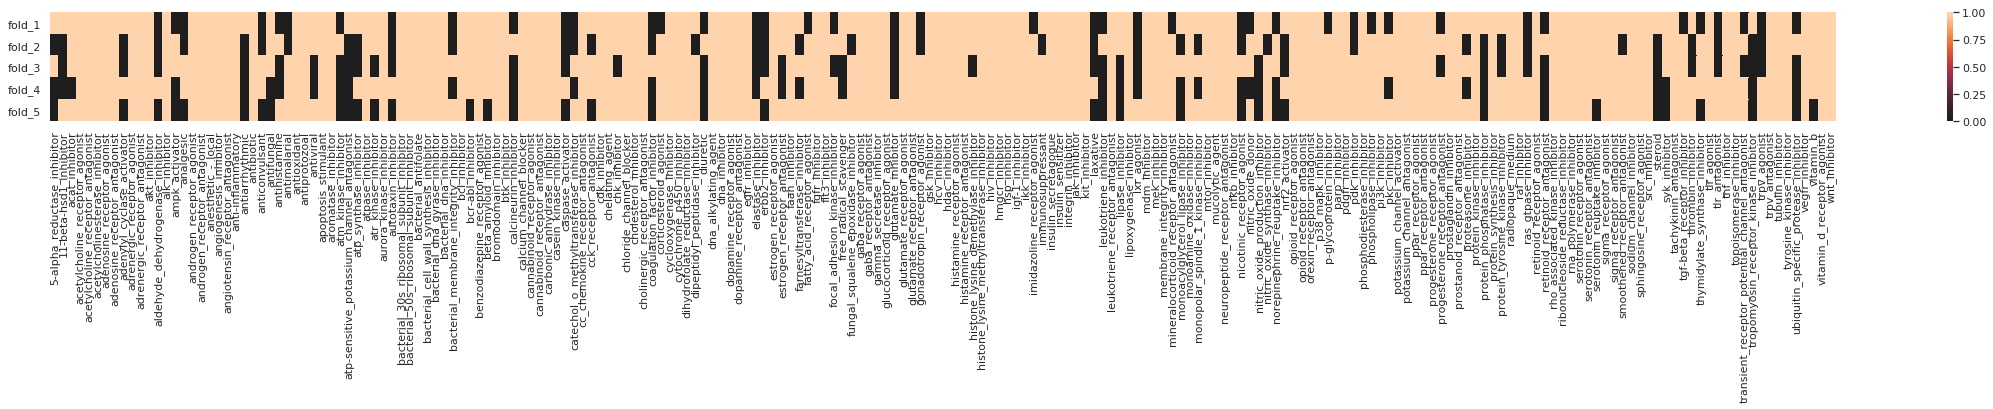

In [197]:
df_bin = df_count.copy()
df_bin[df_count==0] = 0
df_bin[df_count!=0] = 1

df = df_bin
plt.figure(figsize=(40, 2))
sns.heatmap(df,
            xticklabels=df.columns,
            yticklabels=df.index,
            center=0)

<br>

drug GroupKFoldだとどうなる？

In [208]:
target_trt = train_targets[mask_trt & ~mask_top8].copy()
folds = np.full(len(target_trt), -1)

splitter = GroupKFold(n_splits=n_splits)
for i, (trn_idx, val_idx) in enumerate(splitter.split(target_trt, groups=train_drug[mask_trt & ~mask_top8].drug_id)):
    folds[val_idx] =  i + 1
target_trt['fold'] = folds

In [209]:
list_df = []
for n in range(1, n_splits+1):
    mask_fold = target_trt['fold'] == n
    count = train_targets[mask_trt & ~mask_top8][mask_fold].sum(axis=0).values
    df_count = pd.DataFrame([count], columns=train_targets.columns)
    list_df.append(df_count)
df_count = pd.concat(list_df, axis=0)
df_count.index = [f'fold_{i}' for i in range(1, n_splits+1)]
df_count

,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,adrenergic_receptor_agonist,...,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
fold_1,0,0,0,56,95,12,6,31,0,43,...,0,0,24,24,13,0,43,19,1,12
fold_2,0,0,6,23,37,0,6,23,0,101,...,0,6,6,19,24,0,36,6,12,6
fold_3,0,0,0,44,42,6,30,6,12,43,...,0,6,6,41,24,0,0,1,7,12
fold_4,17,12,12,24,54,31,0,19,0,41,...,0,13,12,12,12,0,38,0,12,0
fold_5,0,6,6,43,73,24,12,17,0,42,...,6,0,0,24,0,6,53,0,7,0


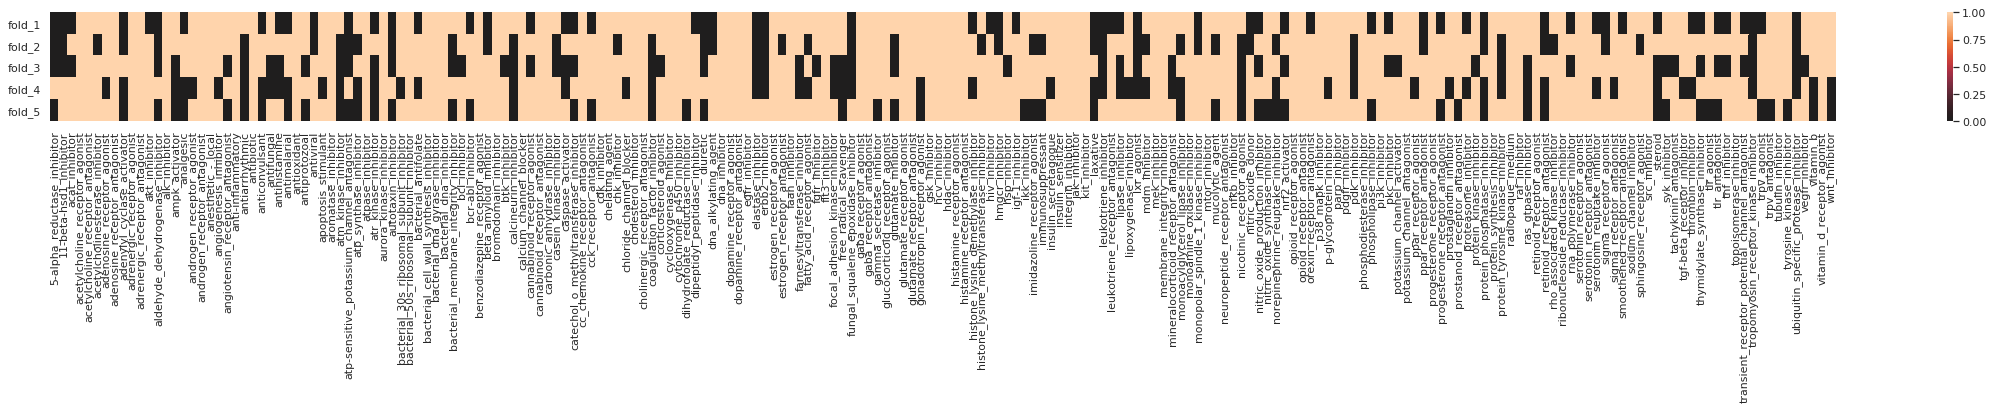

In [210]:
df_bin = df_count.copy()
df_bin[df_count==0] = 0
df_bin[df_count!=0] = 1

df = df_bin
plt.figure(figsize=(40, 2))
sns.heatmap(df,
            xticklabels=df.columns,
            yticklabels=df.index,
            center=0)

---> あれ、意外と悪いな...